**Table of contents**<a id='toc0_'></a>    
- [Group 1](#toc1_)    
    - [Marc Bitar, Davin Patel, Rishabh Jain, Beau Tse](#toc1_1_1_)    
  - [Import and Load Data](#toc1_2_)    
- [Preprocess](#toc2_)    
        - [Import Data into code](#toc2_1_1_1_1_)    
        - [Scale the data](#toc2_1_1_1_2_)    
    - [Problems](#toc2_1_2_)    
- [Predicting the Need for Educational Support](#toc3_)    
      - [Models](#toc3_1_1_1_)    
        - [Random Forest](#toc3_1_1_1_1_)    
      - [Logistic Regression Model](#toc3_1_1_2_)    
- [Which feature are most influential on alcohol consumptions, comparison between weekday and weekend](#toc4_)    
  - [DALC](#toc4_1_)    
          - [Dalc ~ choosen because we are examining school factors on alcohol consumption which transpires on week days](#toc4_1_1_1_1_1_)    
    - [Random Forest Entropy](#toc4_1_2_)    
    - [Logistic Regression](#toc4_1_3_)    
  - [Walc](#toc4_2_)    
    - [Random Forest Entropy](#toc4_2_1_)    
    - [Logistic Regression](#toc4_2_2_)    
- [Can we predict if kids are interested in higher education and target these students](#toc5_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Group 1](#toc0_)
### <a id='toc1_1_1_'></a>[Marc Bitar, Davin Patel, Rishabh Jain, Beau Tse](#toc0_)


## <a id='toc1_2_'></a>[Import and Load Data](#toc0_)

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# <a id='toc2_'></a>[Preprocess](#toc0_)

##### <a id='toc2_1_1_1_1_'></a>[Import Data into code](#toc0_)

In [2]:
df_math = pd.read_csv('Maths.csv')
df_portuguese = pd.read_csv('Portuguese.csv')

In [3]:
df_math['subject'] = 'math'
df_portuguese['subject'] = 'portuguese'

In [4]:
df = pd.concat([df_math, df_portuguese])

##### <a id='toc2_1_1_1_2_'></a>[Scale the data](#toc0_)

In [5]:
df['Average_Grade'] = df[['G1', 'G2', 'G3']].mean(axis=1)

In [6]:
df.loc[(df['Average_Grade'] >= 0) & (df['Average_Grade'] < 10), 'Average_Grade'] = 0
df.loc[(df['Average_Grade'] >= 10) & (df['Average_Grade'] < 14), 'Average_Grade'] = 1
df.loc[(df['Average_Grade'] >= 14) & (df['Average_Grade'] <= 16), 'Average_Grade'] = 2
df.loc[(df['Average_Grade'] > 16) & (df['Average_Grade'] <= 20), 'Average_Grade'] = 3

### <a id='toc2_1_2_'></a>[Problems](#toc0_)

# <a id='toc3_'></a>[Predicting the Need for Educational Support](#toc0_)

In [7]:
continuous_columns = ['age']
nominal_columns = ['school','sex' ,'address' ,'famsize' ,'Pstatus','Medu' ,'Fedu','Mjob' ,'Fjob','reason' ,'guardian','traveltime',
'studytime','famsup' ,'paid' ,'activities' ,'nursery' ,'higher' ,'internet' ,'romantic', 'subject']
ordinal_columns = ['famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health']

In [8]:
X = df[['age','school','sex' ,'address' ,'famsize' ,'Pstatus','Medu' ,'Fedu','Mjob' ,'Fjob','reason' ,'guardian','traveltime',
'studytime','famsup' ,'paid' ,'activities' ,'nursery' ,'higher' ,'internet' ,'romantic', 'subject',
'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health']]
y = df['schoolsup']

In [9]:
from sklearn.impute import SimpleImputer
preprocessor = ColumnTransformer(
    transformers=[
        ('nominal', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown = 'ignore'))
        ]), nominal_columns),
        ('ordinal', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OrdinalEncoder())
        ]), ordinal_columns),
        ('continuous', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), continuous_columns),
    ],
    remainder='drop'
)

#### <a id='toc3_1_1_1_'></a>[Models](#toc0_)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X,  y, shuffle = True, random_state = 42)

##### <a id='toc3_1_1_1_1_'></a>[Random Forest](#toc0_)

In [11]:
# Define the pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, criterion='gini'))
])

# Define the parameter grid for grid search
param_grid = {
    'classifier__n_estimators': [400, 800, 1100],
    'classifier__max_depth': [None, 5, 10],
    'classifier__min_samples_split': [2, 5, 10]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, scoring='roc_auc', cv=5)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
rand_forest_auc_score = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])

print("AUC Score:", rand_forest_auc_score)


AUC Score: 0.8478002378121284


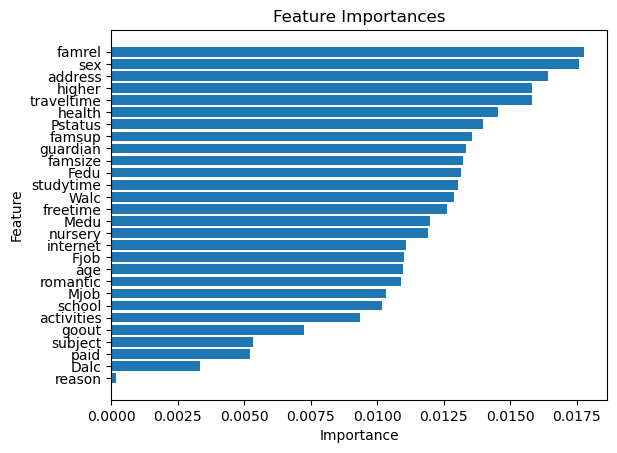

In [12]:
import matplotlib.pyplot as plt
# Get the Random Forest Classifier model from the pipeline
rand_forest = best_model.named_steps['classifier']

# Get the feature importances from the Random Forest Classifier model
importances = rand_forest.feature_importances_

# Get the feature names from the dataset
feature_names = list(X_train.columns)

# Create a dictionary where the keys are the feature names and the values are the feature importances
feature_importances = dict(zip(feature_names, importances))

# Sort the dictionary by the feature importance values in ascending order
sorted_feature_importances = dict(sorted(feature_importances.items(), key=lambda item: item[1], reverse=False))

# Plot the results in a horizontal bar chart
plt.barh(list(sorted_feature_importances.keys()), list(sorted_feature_importances.values()))
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

#### <a id='toc3_1_1_2_'></a>[Logistic Regression Model](#toc0_)

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# Define the pipeline
pipeline = Pipeline([
    
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, solver='liblinear'))
])

# Define the parameter grid for grid search
param_grid = {
    'classifier__C': [0.001, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2']
}
# Perform grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, scoring='roc_auc', cv=5)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
log_reg_auc_score = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])

# Get the optimal parameters
optimal_params = grid_search.best_params_

# Output the results
print("AUC Score:", log_reg_auc_score)
print("Optimal Parameters:", optimal_params)



AUC Score: 0.7079369797859691
Optimal Parameters: {'classifier__C': 10, 'classifier__penalty': 'l2'}


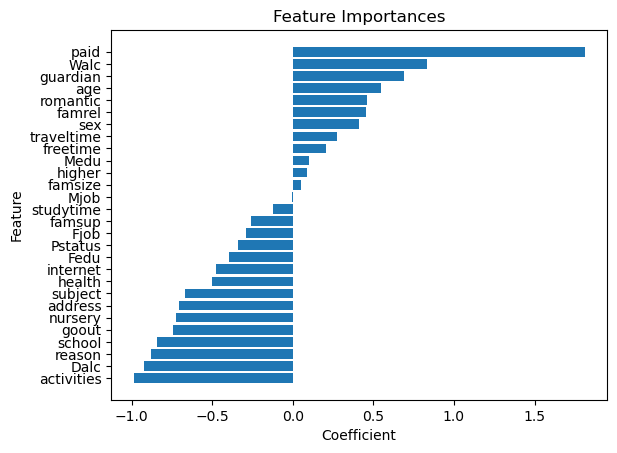

In [14]:
import matplotlib.pyplot as plt

# Get the logistic regression model from the pipeline
log_reg = best_model.named_steps['classifier']

# Get the coefficients from the logistic regression model
coefficients = log_reg.coef_[0]

# Get the feature names from the preprocessor
feature_names = list(X_train.columns)

# Create a dictionary where the keys are the feature names and the values are the coefficients
feature_importances = dict(zip(feature_names, coefficients))

# Sort the dictionary by the coefficient values in ascending order
sorted_feature_importances = dict(sorted(feature_importances.items(), key=lambda item: item[1], reverse=False))

# Plot the results in a horizontal bar chart
plt.barh(list(sorted_feature_importances.keys()), list(sorted_feature_importances.values()))
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

In [17]:
# Define the pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Define the parameter grid for grid search
param_grid = {
    'classifier__max_depth': [None, 5, 10],
    'classifier__min_samples_split': [2, 5, 10]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, scoring='roc_auc', cv=5)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
decision_tree_auc_score = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])

print("AUC Score:", decision_tree_auc_score)

AUC Score: 0.6854191438763377


In [18]:
# Define the pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

# Define the parameter grid for grid search
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__learning_rate': [0.1, 0.05, 0.01],
    'classifier__max_depth': [3, 5, 7]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, scoring='roc_auc', cv=5)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
gb_auc_score = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])

print("AUC Score:", gb_auc_score)


AUC Score: 0.7990487514863257


In [19]:
X_preprocessed = preprocessor.fit_transform(X)

In [20]:
y_new = y.map({'yes': 1, 'no': 0})
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y_new, shuffle = True, random_state = 42)

In [21]:
param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7]
}

# Create an XGBoost classifier
xgb_classifier = XGBClassifier(random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(xgb_classifier, param_grid, scoring='roc_auc', cv=5)
grid_search.fit(X_train, y_train)

# Get the best model and its AUC score
best_model = grid_search.best_estimator_
xgb_auc_score = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])

# Print the best parameters and AUC score
print("Best Parameters:", grid_search.best_params_)
print("AUC Score:", xgb_auc_score)


Best Parameters: {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 300}
AUC Score: 0.7030321046373365


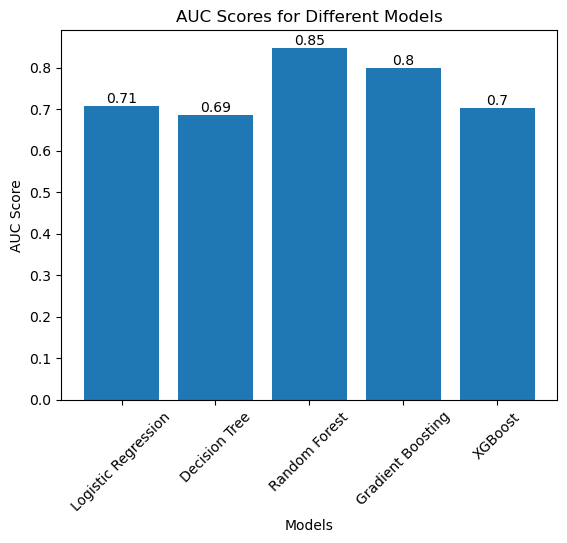

0.7079369797859691 0.6854191438763377 0.8478002378121284 0.7990487514863257 0.7030321046373365


In [22]:
import matplotlib.pyplot as plt

# Define the scores
scores = [log_reg_auc_score, decision_tree_auc_score, rand_forest_auc_score, gb_auc_score, xgb_auc_score]

# Define the labels
labels = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 'XGBoost']

# Create the bar chart
plt.bar(labels, scores)

# Add labels and title
plt.xlabel('Models')
plt.ylabel('AUC Score')
plt.title('AUC Scores for Different Models')

for i, score in enumerate(scores):
    plt.text(i, score, str(round(score, 2)), ha='center', va='bottom')

plt.xticks(rotation=45)

# Display the chart
plt.show()
print(log_reg_auc_score, decision_tree_auc_score, rand_forest_auc_score, gb_auc_score, xgb_auc_score)

# <a id='toc4_'></a>[Which feature are most influential on alcohol consumptions, comparison between weekday and weekend](#toc0_)

## <a id='toc4_1_'></a>[DALC](#toc0_)

###### <a id='toc4_1_1_1_1_1_'></a>[Dalc ~ choosen because we are examining school factors on alcohol consumption which transpires on week days](#toc0_)

In [32]:
continuous_columns = ['age', 'absences', 'G1', 'G2', 'G3', 'Average_Grade']
nominal_columns = ['school','sex' ,'address' ,'famsize' ,'Pstatus','Medu' ,'Fedu','Mjob' ,'Fjob','reason' ,'guardian','traveltime',
'studytime','failures','schoolsup' ,'famsup' ,'paid' ,'activities' ,'nursery' ,'higher' ,'internet' ,'romantic', 'subject']
ordinal_columns = ['famrel', 'freetime', 'goout', 'health']


total_cols = nominal_columns  + ordinal_columns + continuous_columns

In [33]:
df['avg_alcohol'] = (df['Dalc'] + df['Walc']) / 2


In [34]:
X = df[total_cols]
y = df['Dalc']

In [35]:
from sklearn.impute import SimpleImputer
preprocessor = ColumnTransformer(
    transformers=[
        ('nominal', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown = 'ignore'))
        ]), nominal_columns),
        ('ordinal', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OrdinalEncoder())
        ]), ordinal_columns),
        ('continuous', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), continuous_columns),
    ],
    remainder='drop'
)

In [36]:
X_preprocessed = preprocessor.fit_transform(X)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, shuffle = True, random_state = 42)

### <a id='toc4_1_2_'></a>[Random Forest Entropy](#toc0_)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X,  y, shuffle = True, random_state = 42)

In [39]:
from sklearn.impute import SimpleImputer
preprocessor = ColumnTransformer(
    transformers=[
        ('nominal', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown = 'ignore'))
        ]), nominal_columns),
        ('ordinal', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OrdinalEncoder())
        ]), ordinal_columns)
    ],
    remainder='drop'
)

In [40]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

# Define the pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, criterion='gini'))
])

# Define the parameter grid for grid search
param_grid = {
    'classifier__n_estimators': [400, 800, 1100],
    'classifier__max_depth': [None, 5, 10],
    'classifier__min_samples_split': [2, 5, 10]
}

In [41]:
# Perform grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best model and its AUC score
best_model = grid_search.best_estimator_
auc_score_ovo = roc_auc_score(y_test, best_model.predict_proba(X_test), multi_class='ovo')

# Using the One-vs-Rest strategy
auc_score_ovr = roc_auc_score(y_test, best_model.predict_proba(X_test), multi_class='ovr')

# Print the AUC scores
print("AUC Score (One-vs-One):", auc_score_ovo)
print("AUC Score (One-vs-Rest):", auc_score_ovr)

AUC Score (One-vs-One): 0.8303566965793407
AUC Score (One-vs-Rest): 0.866119914324044


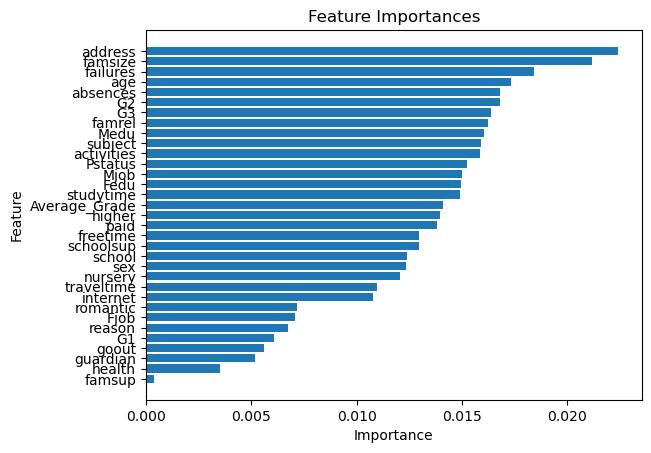

In [42]:
rand_forest = best_model.named_steps['classifier']

# Get the feature importances from the Random Forest Classifier model
importances = rand_forest.feature_importances_

# Get the feature names from the dataset
feature_names = list(X_train.columns)

# Create a dictionary where the keys are the feature names and the values are the feature importances
feature_importances = dict(zip(feature_names, importances))

# Sort the dictionary by the feature importance values in ascending order
sorted_feature_importances = dict(sorted(feature_importances.items(), key=lambda item: item[1], reverse=False))

# Plot the results in a horizontal bar chart
plt.barh(list(sorted_feature_importances.keys()), list(sorted_feature_importances.values()))
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

### <a id='toc4_1_3_'></a>[Logistic Regression](#toc0_)

In [44]:
from sklearn.impute import SimpleImputer
preprocessor = ColumnTransformer(
    transformers=[
        ('nominal', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown = 'ignore'))
        ]), nominal_columns),
        ('ordinal', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OrdinalEncoder())
        ]), ordinal_columns),
        ('continuous', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), continuous_columns),
    ],
    remainder='drop'
)

In [45]:
from sklearn.linear_model import LogisticRegression

# Define the pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, solver='liblinear'))
])

# Define the parameter grid for grid search
param_grid = {
    'classifier__C': [0.001, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2']
}



In [46]:
# Perform grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best model and its AUC score
best_model = grid_search.best_estimator_
auc_score_ovo = roc_auc_score(y_test, best_model.predict_proba(X_test), multi_class='ovo')

# Using the One-vs-Rest strategy
auc_score_ovr = roc_auc_score(y_test, best_model.predict_proba(X_test), multi_class='ovr')

# Print the AUC scores
print("AUC Score (One-vs-One):", auc_score_ovo)
print("AUC Score (One-vs-Rest):", auc_score_ovr)

AUC Score (One-vs-One): 0.6197017537511458
AUC Score (One-vs-Rest): 0.704061818622908


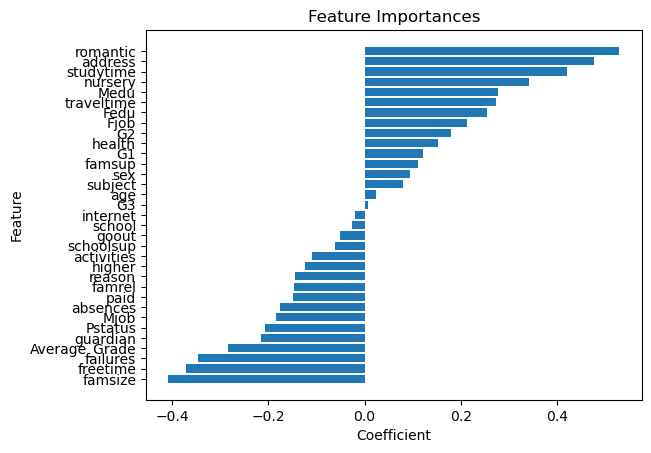

In [47]:
log_reg = best_model.named_steps['classifier']

# Get the coefficients from the logistic regression model
coefficients = log_reg.coef_[0]

# Get the feature names from the preprocessor
feature_names = list(X_train.columns)

# Create a dictionary where the keys are the feature names and the values are the coefficients
feature_importances = dict(zip(feature_names, coefficients))

# Sort the dictionary by the coefficient values in ascending order
sorted_feature_importances = dict(sorted(feature_importances.items(), key=lambda item: item[1], reverse=False))

# Plot the results in a horizontal bar chart
plt.barh(list(sorted_feature_importances.keys()), list(sorted_feature_importances.values()))
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

## <a id='toc4_2_'></a>[Walc](#toc0_)

In [80]:
continuous_columns = ['age', 'absences', 'G1', 'G2', 'G3', 'Average_Grade']
nominal_columns = ['school','sex' ,'address' ,'famsize' ,'Pstatus','Medu' ,'Fedu','Mjob' ,'Fjob','reason' ,'guardian','traveltime',
'studytime','failures','schoolsup' ,'famsup' ,'paid' ,'activities' ,'nursery' ,'higher' ,'internet' ,'romantic', 'subject']
ordinal_columns = ['famrel', 'freetime', 'goout', 'health']


total_cols = nominal_columns  + ordinal_columns + continuous_columns

In [81]:
df['avg_alcohol'] = (df['Dalc'] + df['Walc']) / 2


In [82]:
X = df[total_cols]
y = df['Walc']

In [83]:
from sklearn.impute import SimpleImputer
preprocessor = ColumnTransformer(
    transformers=[
        ('nominal', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown = 'ignore'))
        ]), nominal_columns),
        ('ordinal', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OrdinalEncoder())
        ]), ordinal_columns),
        ('continuous', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), continuous_columns),
    ],
    remainder='drop'
)

In [84]:
X_preprocessed = preprocessor.fit_transform(X)

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, shuffle = True, random_state = 42)

### <a id='toc4_2_1_'></a>[Random Forest Entropy](#toc0_)

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X,  y, shuffle = True, random_state = 42)

In [56]:
from sklearn.impute import SimpleImputer
preprocessor = ColumnTransformer(
    transformers=[
        ('nominal', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown = 'ignore'))
        ]), nominal_columns),
        ('ordinal', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OrdinalEncoder())
        ]), ordinal_columns)
    ],
    remainder='drop'
)

In [57]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

# Define the pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, criterion='gini'))
])

# Define the parameter grid for grid search
param_grid = {
    'classifier__n_estimators': [400, 800, 1100],
    'classifier__max_depth': [None, 5, 10],
    'classifier__min_samples_split': [2, 5, 10]
}

In [58]:
grid_search = GridSearchCV(pipeline, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best model and its AUC score
best_model = grid_search.best_estimator_
auc_score_ovo = roc_auc_score(y_test, best_model.predict_proba(X_test), multi_class='ovo')

# Using the One-vs-Rest strategy
auc_score_ovr = roc_auc_score(y_test, best_model.predict_proba(X_test), multi_class='ovr')

# Print the AUC scores
print("AUC Score (One-vs-One):", auc_score_ovo)
print("AUC Score (One-vs-Rest):", auc_score_ovr)


AUC Score (One-vs-One): 0.9027421948889953
AUC Score (One-vs-Rest): 0.9044902450758974


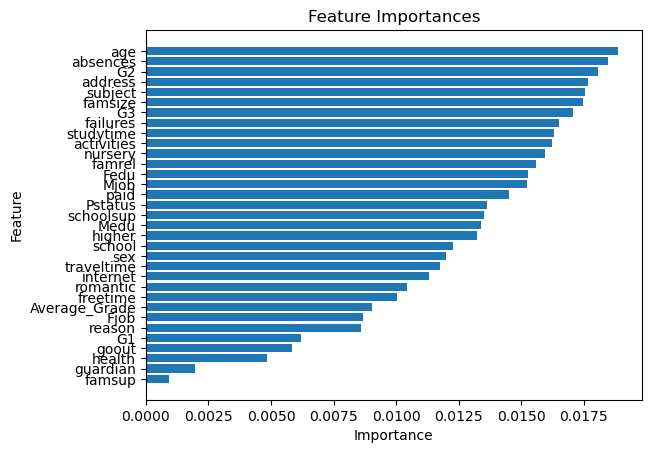

In [59]:
rand_forest = best_model.named_steps['classifier']

# Get the feature importances from the Random Forest Classifier model
importances = rand_forest.feature_importances_

# Get the feature names from the dataset
feature_names = list(X_train.columns)

# Create a dictionary where the keys are the feature names and the values are the feature importances
feature_importances = dict(zip(feature_names, importances))

# Sort the dictionary by the feature importance values in ascending order
sorted_feature_importances = dict(sorted(feature_importances.items(), key=lambda item: item[1], reverse=False))

# Plot the results in a horizontal bar chart
plt.barh(list(sorted_feature_importances.keys()), list(sorted_feature_importances.values()))
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

### <a id='toc4_2_2_'></a>[Logistic Regression](#toc0_)

In [ ]:
from sklearn.impute import SimpleImputer
preprocessor = ColumnTransformer(
    transformers=[
        ('nominal', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown = 'ignore'))
        ]), nominal_columns),
        ('ordinal', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OrdinalEncoder())
        ]), ordinal_columns),
        ('continuous', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), continuous_columns),
    ],
    remainder='drop'
)

In [61]:
from sklearn.linear_model import LogisticRegression

# Define the pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, solver='liblinear'))
])

# Define the parameter grid for grid search
param_grid = {
    'classifier__C': [0.001, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2']
}

In [62]:
# Perform grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best model and its AUC score
best_model = grid_search.best_estimator_
auc_score_ovo = roc_auc_score(y_test, best_model.predict_proba(X_test), multi_class='ovo')

# Using the One-vs-Rest strategy
auc_score_ovr = roc_auc_score(y_test, best_model.predict_proba(X_test), multi_class='ovr')

# Print the AUC scores
print("AUC Score (One-vs-One):", auc_score_ovo)
print("AUC Score (One-vs-Rest):", auc_score_ovr)

AUC Score (One-vs-One): 0.6733524511532754
AUC Score (One-vs-Rest): 0.6852489481917979


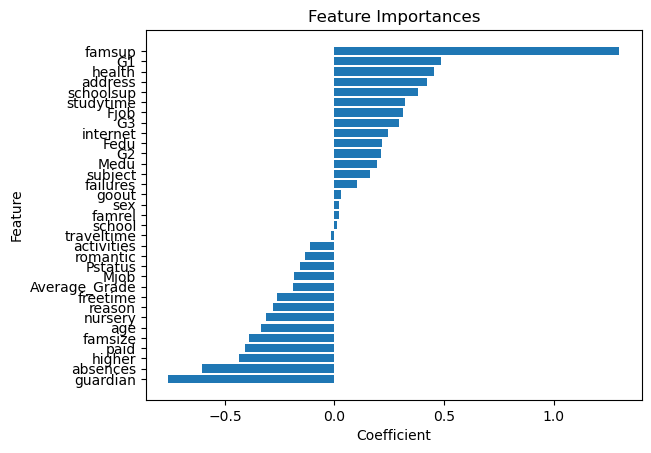

In [63]:
log_reg = best_model.named_steps['classifier']

# Get the coefficients from the logistic regression model
coefficients = log_reg.coef_[0]

# Get the feature names from the preprocessor
feature_names = list(X_train.columns)

# Create a dictionary where the keys are the feature names and the values are the coefficients
feature_importances = dict(zip(feature_names, coefficients))

# Sort the dictionary by the coefficient values in ascending order
sorted_feature_importances = dict(sorted(feature_importances.items(), key=lambda item: item[1], reverse=False))

# Plot the results in a horizontal bar chart
plt.barh(list(sorted_feature_importances.keys()), list(sorted_feature_importances.values()))
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

# <a id='toc5_'></a>[Can we predict if kids are interested in higher education and target these students](#toc0_)

In [64]:
continuous_columns = ['age', 'absences', 'G1', 'G2', 'G3']
nominal_columns = ['school','sex' ,'address' ,'Medu' ,'Fedu','Mjob' ,'Fjob','reason' ,'guardian','traveltime',
                   'studytime','failures','schoolsup' ,'paid' ,'activities' ,'nursery','internet' ,
                   'romantic', 'subject','famsize' , 'Pstatus']
ordinal_columns = ['freetime', 'goout', 'Dalc', 'Walc', 'health']

In [65]:
total_cols = nominal_columns + continuous_columns + ordinal_columns

In [66]:
from sklearn.impute import SimpleImputer
preprocessor = ColumnTransformer(
    transformers=[
        ('nominal', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown = 'ignore'))
        ]), nominal_columns),
        ('ordinal', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OrdinalEncoder())
        ]), ordinal_columns),
        ('continuous', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), continuous_columns),
    ],
    remainder='drop'
)

In [67]:
X = df[total_cols]
y = df['higher']

In [68]:
X_preprocessed = preprocessor.fit_transform(X)

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, shuffle = True, random_state = 42)

In [70]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# Define the logistic regression model
logreg = LogisticRegression(solver = 'saga', max_iter=10000, random_state=42)

# Define the parameter grid for grid search
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2']
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(logreg, param_grid, scoring='roc_auc', cv=5)
grid_search.fit(X_train, y_train)

# Get the best model and its AUC score
best_model = grid_search.best_estimator_
log_reg_auc_score = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])

# Get the best hyperparameters
best_params = grid_search.best_params_

# Output the results
print("Best AUC Score:", log_reg_auc_score)
print("Best Hyperparameters:", best_params)


Best AUC Score: 0.8780905287181437
Best Hyperparameters: {'C': 0.1, 'penalty': 'l2'}


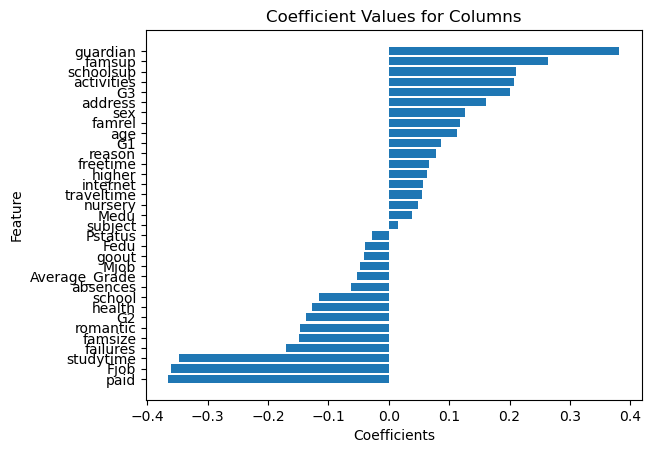

In [91]:
best_logistic_regression = grid_search.best_estimator_
best_coefficients = best_logistic_regression.coef_
result_dict = {col: coef for col, coef in zip(total_cols, best_coefficients[0])}

sorted_keys = sorted(result_dict, key=result_dict.get, reverse=False)
sorted_values = [result_dict[key] for key in sorted_keys]

plt.barh(sorted_keys, sorted_values)
plt.xlabel('Coefficients')
plt.ylabel('Feature')
plt.title('Coefficient Values for Columns')
plt.show()


In [24]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

# Define the decision tree classifier
dt_classifier = DecisionTreeClassifier()

# Define the parameter grid for grid search
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(dt_classifier, param_grid, scoring='roc_auc', cv=5)
grid_search.fit(X_train, y_train)

# Get the best model and its AUC score
best_model = grid_search.best_estimator_
dec_tree_auc_score = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])

# Get the best hyperparameters
best_params = grid_search.best_params_

# Output the results
print("Best AUC Score:", dec_tree_auc_score)
print("Best Hyperparameters:", best_params)


Best AUC Score: 0.745245340433625
Best Hyperparameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5}


In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10],
    'min_samples_split': [2, 5, 10]
}

# Create a random forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(rf_classifier, param_grid, scoring='roc_auc', cv=5)
grid_search.fit(X_train, y_train)

# Get the best model and its AUC score
best_model = grid_search.best_estimator_
rand_for_auc_score = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])

# Print the best parameters and AUC score
print("Best Parameters:", grid_search.best_params_)
print("AUC Score:", rand_for_auc_score)


Best Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 300}
AUC Score: 0.9121338912133892


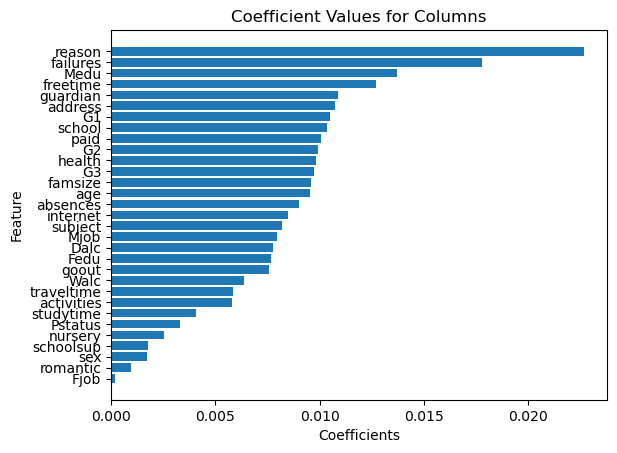

In [26]:
total_cols = continuous_columns + nominal_columns + ordinal_columns
best_model = grid_search.best_estimator_
best_coefficients = best_model.feature_importances_
result_dict = {col: coef for col, coef in zip(total_cols, best_coefficients)}
import matplotlib.pyplot as plt

result_dict = {col: coef for col, coef in zip(total_cols, best_coefficients)}

sorted_keys = sorted(result_dict, key=result_dict.get, reverse=False)
sorted_values = [result_dict[key] for key in sorted_keys]

plt.barh(sorted_keys, sorted_values)
plt.xlabel('Coefficients')
plt.ylabel('Feature')
plt.title('Coefficient Values for Columns')
plt.show()


In [27]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

# Define the parameter grid for grid search
param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7]
}

# Create a gradient boosting classifier
gb_classifier = GradientBoostingClassifier(random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(gb_classifier, param_grid, scoring='roc_auc', cv=5)
grid_search.fit(X_train, y_train)

# Get the best model and its AUC score
best_model = grid_search.best_estimator_
grad_boost_auc_score = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])

# Print the best parameters and AUC score
print("Best Parameters:", grid_search.best_params_)
print("AUC Score:", grad_boost_auc_score)


Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
AUC Score: 0.892734880182579


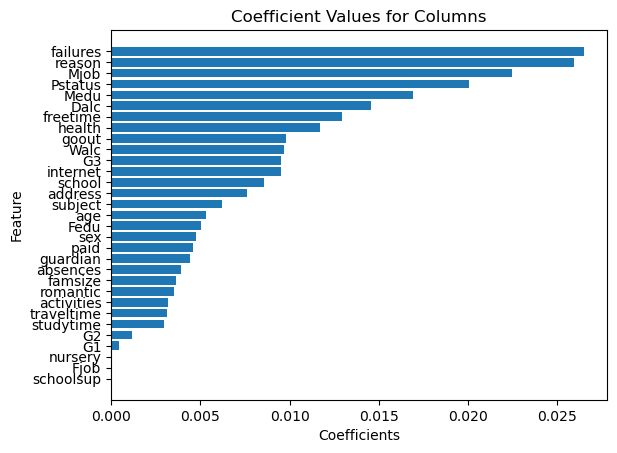

In [28]:
total_cols = continuous_columns + nominal_columns + ordinal_columns
best_model = grid_search.best_estimator_
best_coefficients = best_model.feature_importances_
result_dict = {col: coef for col, coef in zip(total_cols, best_coefficients)}
import matplotlib.pyplot as plt

result_dict = {col: coef for col, coef in zip(total_cols, best_coefficients)}

sorted_keys = sorted(result_dict, key=result_dict.get, reverse=False)
sorted_values = [result_dict[key] for key in sorted_keys]

plt.barh(sorted_keys, sorted_values)
plt.xlabel('Coefficients')
plt.ylabel('Feature')
plt.title('Coefficient Values for Columns')
plt.show()


In [29]:
y_new = y.map({'yes': 1, 'no': 0})
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y_new, shuffle = True, random_state = 42)

In [30]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

# Define the parameter grid for grid search
param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7]
}

# Create an XGBoost classifier
xgb_classifier = XGBClassifier(random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(xgb_classifier, param_grid, scoring='roc_auc', cv=5)
grid_search.fit(X_train, y_train)

# Get the best model and its AUC score
best_model = grid_search.best_estimator_
xgb_auc_score = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])

# Print the best parameters and AUC score
print("Best Parameters:", grid_search.best_params_)
print("AUC Score:", xgb_auc_score)


Best Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100}
AUC Score: 0.9252567516165843


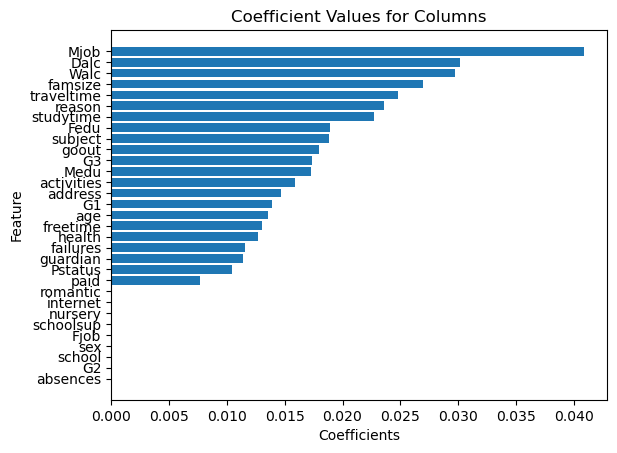

In [31]:
total_cols = continuous_columns + nominal_columns + ordinal_columns
best_model = grid_search.best_estimator_
best_coefficients = best_model.feature_importances_
result_dict = {col: coef for col, coef in zip(total_cols, best_coefficients)}
import matplotlib.pyplot as plt

result_dict = {col: coef for col, coef in zip(total_cols, best_coefficients)}

sorted_keys = sorted(result_dict, key=result_dict.get, reverse=False)
sorted_values = [result_dict[key] for key in sorted_keys]

plt.barh(sorted_keys, sorted_values)
plt.xlabel('Coefficients')
plt.ylabel('Feature')
plt.title('Coefficient Values for Columns')
plt.show()


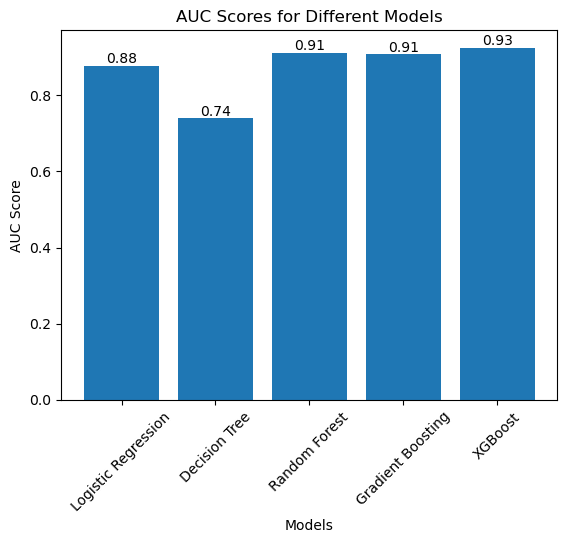

0.8780905287181437 0.7391593761886648 0.9121338912133892 0.9077596044123241 0.9252567516165843


In [30]:
import matplotlib.pyplot as plt

# Define the scores
scores = [log_reg_auc_score, dec_tree_auc_score, rand_for_auc_score, grad_boost_auc_score, xgb_auc_score]

# Define the labels
labels = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 'XGBoost']

# Create the bar chart
plt.bar(labels, scores)

# Add labels and title
plt.xlabel('Models')
plt.ylabel('AUC Score')
plt.title('AUC Scores for Different Models')

for i, score in enumerate(scores):
    plt.text(i, score, str(round(score, 2)), ha='center', va='bottom')

plt.xticks(rotation=45)

# Display the chart
plt.show()
print(log_reg_auc_score, dec_tree_auc_score, rand_for_auc_score, grad_boost_auc_score, xgb_auc_score)

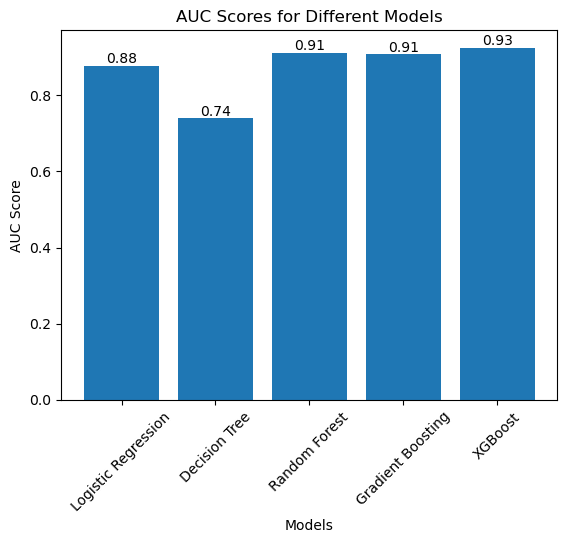

In [31]:
# Create the bar chart
plt.bar(labels, scores)

# Add labels and title
plt.xlabel('Models')
plt.ylabel('AUC Score')
plt.title('AUC Scores for Different Models')

# Display the score at the top of each bar
for i, score in enumerate(scores):
    plt.text(i, score, str(round(score, 2)), ha='center', va='bottom')

plt.xticks(rotation=45)

# Display the chart
plt.show()


In [ ]:
coefficients = lr_classifier.coef_
feature_names = preprocessor.transformers_[0][1]['encoder'].get_feature_names_out(input_features=nominal_columns)
feature_names = feature_names.tolist() + ordinal_columns
coefficients_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients[0]})
print(coefficients_df)


In [94]:
train_df = pd.concat([pd.DataFrame(X_train).reset_index(drop=True), pd.DataFrame(y_train).reset_index(drop=True)], axis=1)
test_df = pd.concat([pd.DataFrame(X_test).reset_index(drop=True), pd.DataFrame(y_test).reset_index(drop=True)], axis=1)

In [95]:
from autogluon.tabular import TabularDataset, TabularPredictor
train_data = TabularDataset(train_df)

In [96]:
from autogluon.tabular import TabularPredictor
save_path = 'any'
label = 'higher' # specifies which column do we want to predict
predictor = TabularPredictor(label=label, path='any').fit(train_data, time_limit=600)


No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets.
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='best_quality'   : Maximize accuracy. Default time_limit=3600.
	presets='high_quality'   : Strong accuracy with fast inference speed. Default time_limit=3600.
	presets='good_quality'   : Good accuracy with very fast inference speed. Default time_limit=3600.
	presets='medium_quality' : Fast training time, ideal for initial prototyping.
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "any"
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.9.6
Operating System:   Darwin
Platform Machine:   x86_64
Platform Version:   Darwin Kernel Version 23.2.0: Wed Nov 15 21:54:10 PST 2023; root:xnu-10002.61.3~2/RELEASE_X86_64
CPU Count:          8
Memory Avail:       2.01 GB /

In [97]:
test_data = TabularDataset(test_df)
y_test = test_data[label] # values to predict

In [98]:
test_data_nolab = test_data.drop(columns=[label])

In [99]:
predictor = TabularPredictor.load(save_path)

In [100]:
y_pred = predictor.predict(test_data_nolab)

In [101]:
perf = predictor.evaluate_predictions(y_true=y_test, y_pred=y_pred, auxiliary_metrics={'auc'})
leaderboard = predictor.leaderboard(test_data, silent=True)
display(leaderboard, perf)

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,0.942529,0.955414,accuracy,0.107627,0.068066,7.207935,0.010283,0.005737,1.526713,2,True,11
1,CatBoost,0.931034,0.942675,accuracy,0.020216,0.006819,1.576435,0.020216,0.006819,1.576435,1,True,5
2,ExtraTreesGini,0.927203,0.917197,accuracy,0.294106,0.136248,2.294068,0.294106,0.136248,2.294068,1,True,6
3,RandomForestGini,0.923372,0.923567,accuracy,0.299551,0.227442,2.289746,0.299551,0.227442,2.289746,1,True,3
4,KNeighborsUnif,0.919540,0.929936,accuracy,0.029448,0.040666,0.027972,0.029448,0.040666,0.027972,1,True,1
5,KNeighborsDist,0.919540,0.929936,accuracy,0.038005,0.032452,0.041682,0.038005,0.032452,0.041682,1,True,2
6,ExtraTreesEntr,0.919540,0.917197,accuracy,0.244180,0.128540,1.376309,0.244180,0.128540,1.376309,1,True,7
7,RandomForestEntr,0.919540,0.923567,accuracy,0.342386,0.129482,2.037728,0.342386,0.129482,2.037728,1,True,4
8,XGBoost,0.911877,0.942675,accuracy,0.029388,0.009746,0.827800,0.029388,0.009746,0.827800,1,True,9
9,NeuralNetTorch,0.908046,0.936306,accuracy,0.057433,0.018707,4.896834,0.057433,0.018707,4.896834,1,True,10


{'accuracy': 0.9425287356321839,
 'balanced_accuracy': 0.6797261316089769,
 'mcc': 0.5473057214040686,
 'f1': 0.969450101832994,
 'precision': 0.9444444444444444,
 'recall': 0.99581589958159}